# Random Forest Exercises

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

## Acquire

In [73]:
# Acquire Step
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [74]:
177 / 891

0.19865319865319866

## Prepare
1. Reduce obvious noise: 
    - Set `passenger_id` to be the index
    - Drop any duplicate columns
2. Look into the nulls
    - Drop the `deck` column due to so many nulls.
    - Fill `embark_town` with the most common value
    - `Age` column is ~20% null. I'm not comfortable dropping that many rows, so let's look into age.
3. One hot encode our string columns using `pd.get_dummies`
4. Split the data into train, validate, and test

In [75]:
# Reduce obvious noise
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])

In [76]:
# What about nulls?
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [77]:
# Drop deck because there are far too many nulls
df = df.drop(columns=["deck"])

In [78]:
# Let's fill embark_town with the most common observation
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [79]:
# Let's investigate the observations with missing age
# My first thought was empty age values might indicate children
# Looks like most of these individuals were traveling alone
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

(<AxesSubplot:>, <AxesSubplot:>)

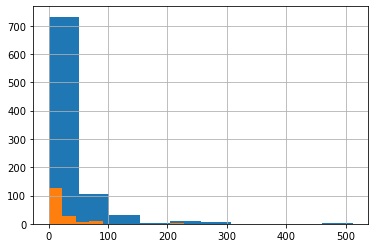

In [80]:
df.fare.hist(), no_age_info.fare.hist()

In [81]:
# Let's see how similar this group is to the population
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print()
    print()

survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64


pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64


sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64


sibsp
Population:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: sibsp, dtype: float64
No age
0    0.774011
1    0.146893
8    0.039548
3    0.022599
2    0.016949
Name: sibsp, dtype: float64


parch
Population:
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: parch, dtype: float64
No age
0    0.887006
2    0.067797
1    0.045198
Name: parch, dtype: float64


embark_town
Population:
Southampton    0.724409
Cherbou

In [82]:
# Looking at the distribution of values, it appears that no age subgroup is very close to the population
# If we needed to be more certain, we could perform hypothesis testing
# It looks like there's nothing wildly different about the no age group compared to the population
# So we'll impute using the median age
df.age = df.age.fillna(value=df.age.median())

## Encoding reminder:
- Southampton, Queenstown, and Cherbourg were the embark towns
- If embark_town_Queenstown and embark_town_Southampton are both 0, then Cherbourg it is!

In [83]:
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [84]:
# Time to split!
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [87]:
train.shape, validate.shape, test.shape

((498, 10), (214, 10), (179, 10))

In [85]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [88]:
X_train.shape, X_validate.shape, X_test.shape

((498, 9), (214, 9), (179, 9))

In [86]:
X_train.head()

,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,
583,1,36.0,0,0,40.1250,1,1,0,0
165,3,9.0,0,2,20.5250,0,1,0,1
50,3,7.0,4,1,39.6875,0,1,0,1
259,2,50.0,0,1,26.0000,0,0,0,1
306,1,28.0,0,0,110.8833,1,0,0,0


## Onto Modeling

In [18]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [90]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.773481,0.801471,0.781124,0.787476,0.784216
recall,0.912052,0.570681,0.781124,0.741366,0.781124
f1-score,0.837070,0.666667,0.781124,0.751868,0.771715
support,307.000000,191.000000,0.781124,498.000000,498.000000


In [70]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,280,82
1,27,109


In [71]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(109, 280, 27, 82)

In [69]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7811244979919679
True Positive Rate: 0.5706806282722513
False Positive Rate: 0.08794788273615635
True Negative Rate: 0.9120521172638436
False Negative Rate: 0.4293193717277487
Precision: 0.8014705882352942
Recall: 0.5706806282722513
F1 Score: 0.6666666666666667
Support (0): 191
Support (1): 307


## Let's get loopy!

In [17]:
# Let's 
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.815029    0.835526  0.821285    0.825278      0.822890
recall       0.918567    0.664921  0.821285    0.791744      0.821285
f1-score     0.863706    0.740525  0.821285    0.802115      0.816462
support    307.000000  191.000000  0.821285  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.836257    0.865385  0.845382    0.850821      0.847429
recall       0.931596    0.706806  0.845382    0.819201      0.845382
f1-score     0.881356    0.778098  0.845382    0.829727      0.841753
support    307.000000  191.000000  0.845382  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.842566    0.883871  0.855422    0.863218      0.858408
recall       0.941368    0.717277  0.855422    0.829323      0.855422
f1-score     

## As we might expect
- The more depth to the tree, the more the model fits to the training data
- But we need to expect more to the story!
- How well the model works on data it hasn't seen before?

In [39]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.821285,0.771028,0.050257
1,3,0.845382,0.794393,0.050989
2,4,0.855422,0.799065,0.056356
3,5,0.865462,0.803738,0.061724
4,6,0.891566,0.813084,0.078482
5,7,0.927711,0.822430,0.105281
6,8,0.945783,0.808411,0.137372
7,9,0.957831,0.803738,0.154093
8,10,0.969880,0.813084,0.156795
9,11,0.977912,0.808411,0.169500


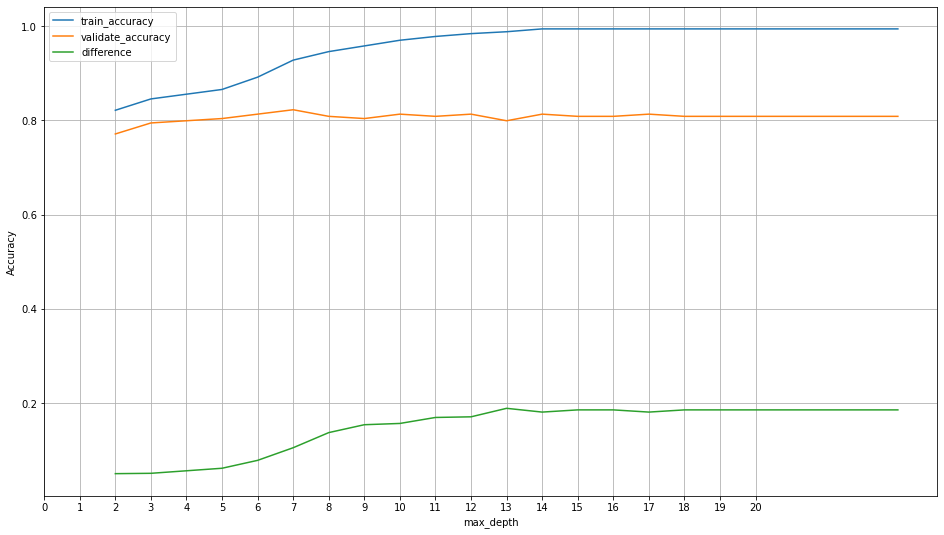

In [24]:
df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

## Increasing `min_samples_per_leaf`, decreasing `max_depth`

In [55]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.925703,0.822430,0.103273
1,3,17,0.901606,0.817757,0.083849
2,4,16,0.887550,0.817757,0.069793
3,5,15,0.877510,0.780374,0.097136
4,6,14,0.871486,0.799065,0.072421
5,7,13,0.869478,0.789720,0.079758
6,8,12,0.865462,0.794393,0.071069
7,9,11,0.857430,0.794393,0.063037
8,10,10,0.857430,0.785047,0.072383
9,11,9,0.849398,0.785047,0.064351


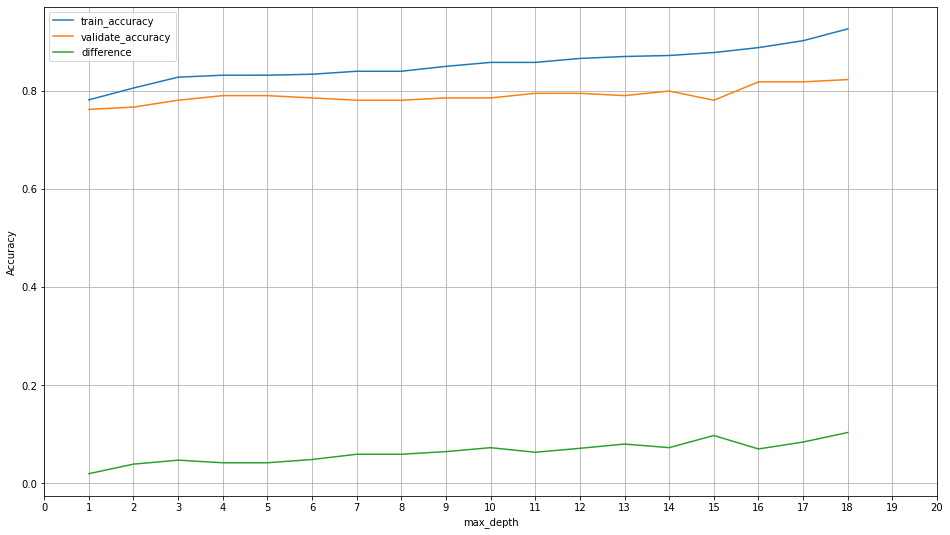

In [57]:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

<AxesSubplot:xlabel='max_depth', ylabel='difference'>

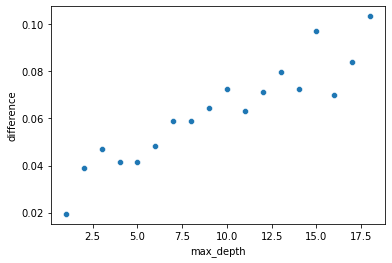

In [21]:
sns.scatterplot(x="max_depth", y="difference", data=df)

<AxesSubplot:xlabel='min_samples_per_leaf', ylabel='difference'>

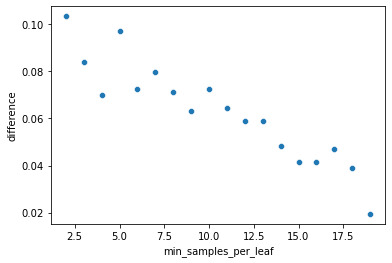

In [22]:
sns.scatterplot(x="min_samples_per_leaf", y="difference", data=df)

<AxesSubplot:xlabel='difference', ylabel='validate_accuracy'>

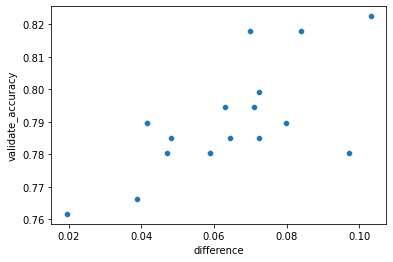

In [23]:
sns.scatterplot(x="difference", y="validate_accuracy", data=df)

## What if we increase both `min_samples_per_leaf` and `max_depth`

In [49]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.821285,0.771028,0.050257
1,3,3,0.845382,0.785047,0.060335
2,4,4,0.847390,0.794393,0.052997
3,5,5,0.859438,0.799065,0.060372
4,6,6,0.861446,0.799065,0.062380
5,7,7,0.863454,0.789720,0.073734
6,8,8,0.863454,0.789720,0.073734
7,9,9,0.855422,0.794393,0.061029
8,10,10,0.857430,0.785047,0.072383
9,11,11,0.849398,0.785047,0.064351


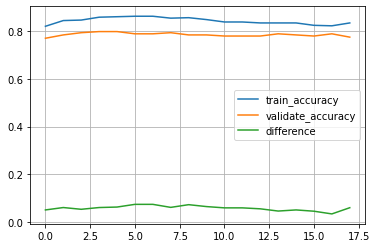

In [54]:
df[['train_accuracy', 'validate_accuracy','difference']].plot()
plt.grid()

## What about a fixed depth and increasing `min_samples_leaf`

In [47]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []


for i in range(2, 50):
    # Make the model
    depth = 5
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,5,0.861446,0.794393,0.067053
1,3,5,0.859438,0.789720,0.069718
2,4,5,0.857430,0.789720,0.067710
3,5,5,0.859438,0.799065,0.060372
4,6,5,0.859438,0.789720,0.069718
5,7,5,0.851406,0.785047,0.066359
6,8,5,0.855422,0.789720,0.065702
7,9,5,0.845382,0.785047,0.060335
8,10,5,0.847390,0.780374,0.067016
9,11,5,0.839357,0.780374,0.058984


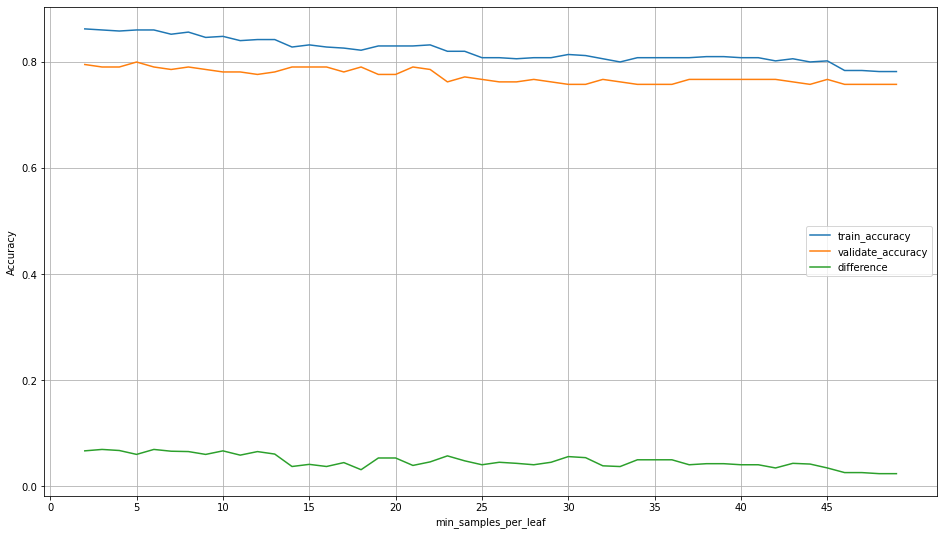

In [48]:
df.set_index('min_samples_per_leaf')[['train_accuracy', 'validate_accuracy', 'difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,50,5))
plt.grid()